# Sentence Transformer Embedding based Topics Modelling and Prediction

Importing Libraries
--

In [1]:
from pre_process import *

Loading Libraries...Just a moment please!...


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gurpreetbedi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Loading dataset
--

In [2]:
path = "/Users/gurpreetbedi/Downloads/Neural/Indeed_local/source_data/"

In [3]:
art_train = load_data(f"{path}article.json")
art_test = load_data(f"{path}pred_article.json")

art_test["cont_title"] = art_test["contentTitle"] + " " +art_test["content"]
art_train["cont_title"] = art_train["contentTitle"] + " " +art_train["content"]

art_test = remove_hyperlinks_html_tags(art_test, "cont_title")
art_train = remove_hyperlinks_html_tags(art_train, "cont_title")

Shape of pre-processed data
--

In [4]:
print("After pre-processing the raw data: ")
print(f'Shape of the article from taining corpus: {art_train.shape}')
print(f'Shape of the article from test corpus: {art_test.shape}')

After pre-processing the raw data: 
Shape of the article from taining corpus: (13639, 8)
Shape of the article from test corpus: (1417, 7)


Load sentence ransformer embeddings
--

In [5]:
content = list(art_train["cont_title"])
title = list(art_train['contentTitle'])

In [6]:
embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
sent_embeddings = Sentence_Encoder(embedding_model).embed_documents(content, device=device)

In [7]:
print(f'Shape of Sentence Transformer embeddings of the articles from training corpus : {art_train.shape}')

Shape of Sentence Transformer embeddings of the articles from training corpus : (13639, 8)


Perform dimensionality reduction and document clustering
--

In [8]:
umap_model = umap.UMAP(n_neighbors=15,
                       n_components=5,
                       metric='cosine')

hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=15,
                                metric='euclidean',
                                cluster_selection_method='eom',
                                prediction_data=True)

umap_data = umap_model.fit_transform(sent_embeddings)
cluster = hdbscan_model.fit(umap_data)

In [9]:
print(f"The number of unqiue topics from HDBSCAN model: {len(np.unique(cluster.labels_))}")

The number of unqiue topics from HDBSCAN model: 187


Save the model for future reference
--

In [10]:
joblib.dump(umap_model, f"/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/umap_model_{len(np.unique(cluster.labels_))}.sav")
joblib.dump(hdbscan_model, f"/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/hdbscan_model_{len(np.unique(cluster.labels_))}.sav")

['/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/hdbscan_model_187.sav']

Different Visualizations of Clustered data
--

In [11]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, metric='cosine').fit_transform(sent_embeddings)

result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]

plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=5, alpha=0.9)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=5, cmap='hsv_r', alpha=0.9)

print(len(clustered), len(outliers))
plt.colorbar()

9210 4429


Scatter plot to show points in space
--

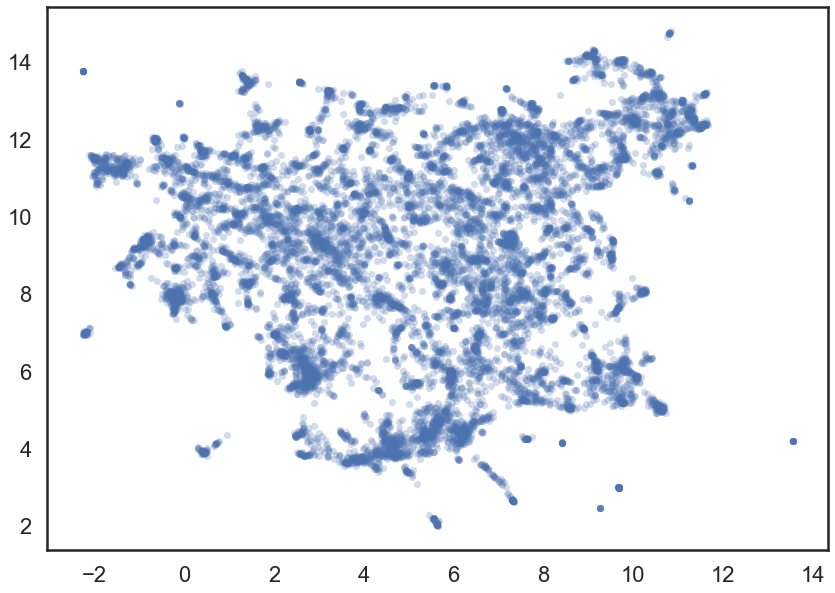

In [12]:
plt.scatter(*umap_data.T, s=50, linewidth=0, c='b', alpha=0.25)

Condensed Tree Plot from HDBSCAN
--

In [13]:
cluster.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette("deep",8))

<AxesSubplot:ylabel='$\\lambda$ value'>

Soft Clustering of the topics in space
--

In [14]:
soft_clusters = hdbscan.all_points_membership_vectors(cluster)

color_palette = sns.diverging_palette(0, len(np.unique(clustered.labels)), n=len(np.unique(clustered.labels)))
cluster_colors = [color_palette[np.argmax(x)] for x in soft_clusters]

plt.scatter(*umap_data.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

Assigning Labels from Clustering to the documents
--

In [15]:
docs_df = pd.DataFrame(content, columns=["Doc"])
docs_df['Title'] = title
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

Topic based TF-IDF
--

In [16]:
def doc_tf_idf(documents, doc_length, ngram_range=(1,1)):
    """
    topic based TF-IDF to create dense clusters allowing for easily interpretable topics
    """
    count = CountVectorizer(ngram_range=ngram_range, stop_words=stop_words).fit(documents)
    terms = count.transform(documents).toarray()
    words = np.sum(terms, axis=1)
    tf = terms.T/words
    sum_terms = np.sum(terms, axis=0)
    idf = np.log(doc_length/sum_terms).reshape(-1, 1)
    tf_idf = tf * idf
    return tf_idf, count
  
tf_idf, count = doc_tf_idf(docs_per_topic.Doc.values, doc_length=len(content), ngram_range=(1,2))

In [17]:
print(f"TF-IDF Shape: {tf_idf.shape}")

TF-IDF Shape: (2969876, 187)


Creating topic words from topic numbers
--

In [18]:
def get_top_n_words(tf_idf, count, docs_per_topic, n=20):
    """
    Get the top words per topic
    """      
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_10_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_10_words

def get_topic_sizes(df):
    """
    Get the document counts clustered for all the topics.
    """    
    topic_sizes = (df.groupby(['Topic']).Doc.count().reset_index().rename({"Topic": "Topic", "Doc": "Doc_Count"}, axis='columns').sort_values("Doc_Count", ascending=False))
    return topic_sizes

top_10_words = get_top_n_words(tf_idf, count, docs_per_topic, n=10)
topic_sizes = get_topic_sizes(docs_df)
topic_sizes.head(10)

Topic  Doc_Count
0       -1       4429
49      48        328
172    171        314
90      89        295
98      97        224
123    122        155
125    124        154
141    140        150
124    123        144
35      34        143

Top 4 topics with maximum size
--

In [19]:
top_10_words[48], top_10_words[171], top_10_words[89], top_10_words[97]

([('resumes', 0.003685611925407836),
  ('summary', 0.0029271195406781907),
  ('format', 0.0024227155033617323),
  ('chronological', 0.0023448991109184577),
  ('section', 0.002140481929918508),
  ('resume template', 0.0020056897953804314),
  ('accomplishments', 0.0019675317067783396),
  ('achievements', 0.0019431198308272576),
  ('awards', 0.0018812211131945806),
  ('sections', 0.0018570117632720985)],
 [('target', 0.002924012457322473),
  ('consumers', 0.0027917966867313506),
  ('selling', 0.0027225954328455298),
  ('segmentation', 0.002371861991022459),
  ('campaign', 0.002246131729706777),
  ('purchase', 0.002229152830929268),
  ('marketing strategy', 0.0021756025230339976),
  ('consumer', 0.002173269318233529),
  ('advertising', 0.0021202677851826324),
  ('audience', 0.002088851765367439)],
 [('nurse', 0.008931805302157985),
  ('nurses', 0.008873575310360019),
  ('nursing', 0.008821542471926272),
  ('rn', 0.005997428613684083),
  ('registered', 0.0053136447976966485),
  ('registered

Heatmap for top 30 topics
--

In [20]:
df = pd.DataFrame(topic_sizes).reset_index()
df = df.drop(columns=["index"])
topics = df.Topic.values.tolist()[:30]
fig, _= heatmap_visualization(tf_idf, topics, top_10_words)
fig

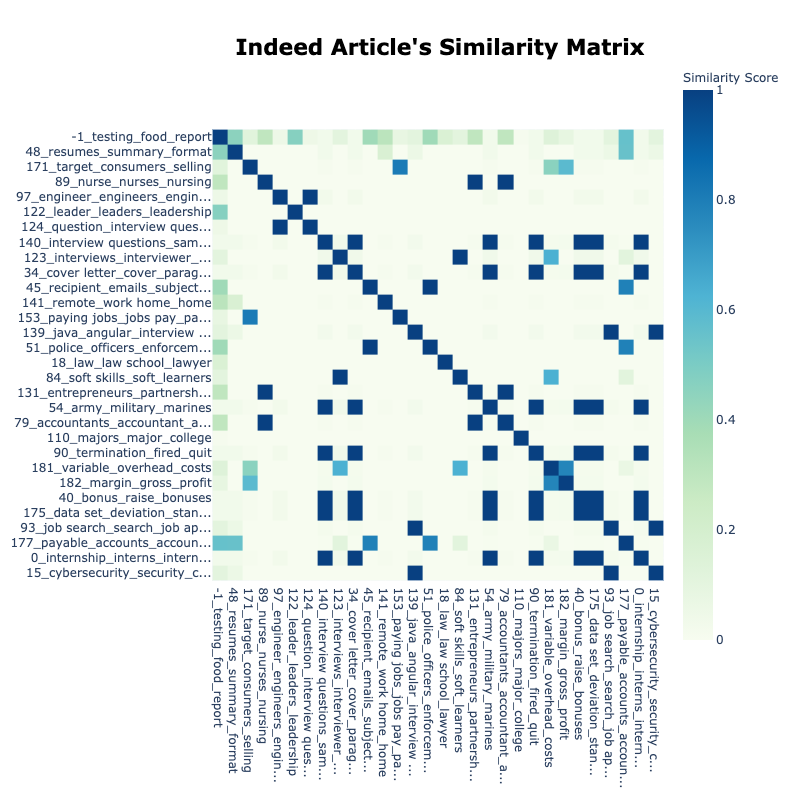

In [21]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (27).png") 

Heatmap for all topics
--

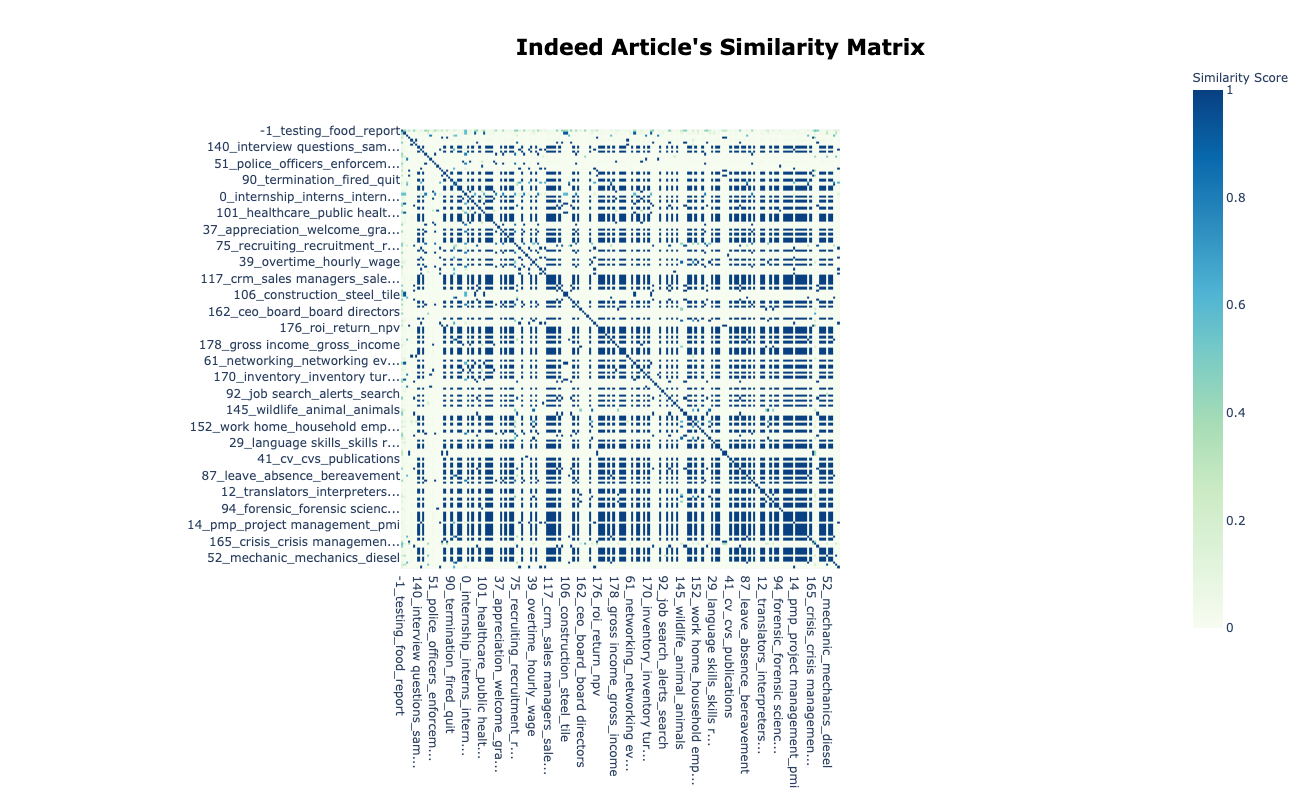

In [22]:
df = pd.DataFrame(topic_sizes).reset_index()
df = df.drop(columns=["index"])
topics = df.Topic.values.tolist()
fig, _= heatmap_visualization(tf_idf, topics, top_10_words)
fig

In [23]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (28).png") 

2-D Plotly Visualization of topics in Space
--

In [24]:
def get_colors(topics, topic_list):
    """
    Get the color marker for the topics inside the topics list
    """          
    if topics == -1:
        marker = ["#B0BEC5" for _ in topic_list[1:]]
    else:
        marker = ["red" if topic == topics else "#B0BEC5" for topic in topic_list[1:]]
    return [{'marker_color': [marker]}]   

def get_topic(topic):
    """
    Get a particular topic from all the topics
    """           
    return top_10_words[topic]

def get_topics():         
    """
    Get a all the topics in a dictionary
    """          
    return top_10_words

def get_topic_freq(topic= None):
    """
    Get document count per topic which will be the size of the topic
    """    
    if isinstance(topic, int):
        return topic_sizes[topic]
    else:
        return topic_sizes
    
def topic_visualization_fotmatting(df, topic_list, width, height):
    """
    Format topic visulization using the co-ordinates provided in the datafarme and list of topics
    """
    # Prepare figure range
    x_range = (df.x.min() - abs((df.x.min()) * .15), df.x.max() + abs((df.x.max()) * .15))
    y_range = (df.y.min() - abs((df.y.min()) * .15), df.y.max() + abs((df.y.max()) * .15))

    # Plot topics
    fig = px.scatter(df, x="x", y="y", size="Size", size_max=40, template="simple_white", labels={"x": "", "y": ""},
                     hover_data={"x": False, "y": False, "Topic": True, "Words": True, "Size": True})
    fig.update_traces(marker=dict(color="#7f91eb", line=dict(width=2, color='DarkSlateGrey'))) #"#B0BEC5"

    # Update hover order
    fig.update_traces(hovertemplate="<br>".join(["<b>Topic %{customdata[0]}</b>",
                                                 "Words: %{customdata[1]}",
                                                 "Count: %{customdata[2]}"]))   
    
    # Create a slider for topic selection
    steps = [dict(label=f"Topic {topic}", method="update", args=get_colors(topic,topic_list)) for topic in topic_list[1:]]
    sliders = [dict(active=0, pad={"t": 50}, steps=steps)]

    # Stylize layout
    fig.update_layout(
                        title={'text': "<b>Indeed's Intertopic Distance", 'y': .95, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top', 'font': dict(size=22,color="Black")},
                        width=width,
                        height=height,
                        hoverlabel=dict(
                            bgcolor="white",
                            font_size=14,
                            font_family="Rockwell"
        ),
        xaxis={"visible": False},
        yaxis={"visible": False},
        sliders=sliders
    )

    fig.update_xaxes(range=x_range)
    fig.update_yaxes(range=y_range)


    fig.add_shape(type="line",
                  x0=sum(x_range)/2, y0=y_range[0], x1=sum(x_range) / 2, y1=y_range[1],
                  line=dict(color="#CFD8DC", width=2))
    fig.add_shape(type="line",
                  x0=x_range[0], y0=sum(y_range)/2, x1=x_range[1], y1=sum(y_range) / 2,
                  line=dict(color="#9E9E9E", width=2))
    fig.add_annotation(x=x_range[0], y=sum(y_range) / 2, text="D1", showarrow=False, yshift=10)
    fig.add_annotation(y=y_range[1], x=sum(x_range) / 2, text="D2", showarrow=False, xshift=10)
    fig.data = fig.data[::-1]

    return fig

In [25]:
def topics_viz_data(topics, width, height):
    """
    Creates Topic Visalization in 2D space. Each topic taking shape as the sice of the documents clustered in each topic
    """       
    topics = sorted(list(get_topics().keys()))
    frequencies = [topic_sizes[topic_sizes["Topic"]==topic]["Doc_Count"].values[0] for topic in topics]
    words = [" | ".join([word[0] for word in get_topic(topic)[:5]]) for topic in topics]

    indices = np.array([topics.index(topic) for topic in topics])

    embeddings = tf_idf[indices]
    embeddings = MinMaxScaler().fit_transform(embeddings)
    embeddings = umap.UMAP(n_neighbors=2, n_components=2, metric='hellinger').fit_transform(embeddings)

    df = pd.DataFrame({"x": embeddings[1:, 0], "y": embeddings[1:, 1],
                       "Topic": topics[1:], "Words": words[1:], "Size": frequencies[1:]})
    fig = topic_visualization_fotmatting(df, topics, width, height)

    return fig, embeddings, df


In [26]:
def visualize_topics(topics = None, width = 1000, height = 1000):
    """
    Format topic visulization using the co-ordinates provided in the datafarme and list of topics
    """    
    fig,_,_= topics_viz_data(topics=topics,
                             width=width,
                             height=height)
    return fig

In [27]:
topics = docs_per_topic.Topic.tolist()
fig = visualize_topics(topics)

In [28]:
fig

In [29]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (29).png") 

**Note: This figure is interactive, know plotly issue due to which the figure is not visible on Github.**

Topic Dendograms depicting the hierarchy of topics
--

In [30]:
def topics_dendrogram(embeddings, orientation="left", width = 1000, height = 1000):
    """
    Creates a Dendogram in topic space using sentence transformer embeddings
    """    
    embeddings = np.array(embeddings)
    topics_list = sorted(list(get_topics().keys()))
    topics_lookup = {topic:i for i, topic in enumerate(topics_list)}
    indices = np.array([topics_lookup[topic] for topic in topics_list])
    embeddings = embeddings[indices]

    # Create dendogram
    distance_matrix = 1 - cosine_similarity(embeddings)
    fig = ff.create_dendrogram(distance_matrix,
                               orientation=orientation,
                               linkagefun=lambda x: linkage(x, "ward"),
                               color_threshold=1)

    # Create nicer labels
    axis = "yaxis" if orientation == "left" else "xaxis"
    new_labels = [[[str(topics_list[int(x)]), None]] + get_topic(topics_list[int(x)])
                  for x in fig.layout[axis]["ticktext"]]
    new_labels = ["_".join([label[0] for label in labels[:4]]) for labels in new_labels]
    new_labels = [label if len(label) < 30 else label[:27] + "..." for label in new_labels]

    # Stylize layout
    fig.update_layout(plot_bgcolor="#ECEFF1",
                      template="plotly_white",
                      title={'text': "<b>Indeed's Article Clustering", "y": .95, "x": 0.5, "xanchor": 'center', "yanchor": "top", "font": dict(size=22, color="Black")},
                      width=width,
                      height=height,
                      hoverlabel=dict(bgcolor="white", font_size=16,font_family="Rockwell"),

    )

    # Stylize orientation
    if orientation == "left":
        fig.update_layout(yaxis=dict(tickmode="array",
                                     ticktext=new_labels))
    else:
        fig.update_layout(xaxis=dict(tickmode="array",
                                     ticktext=new_labels))
    return fig

Create Topic embeddings
--

In [31]:
def create_topic_embeddings(embeddings):
    topic_list = list(get_topics().keys())
    topic_list.sort()
    topic_embeddings = []
    for i, topic in enumerate(topic_list):
        indexes = np.array(docs_df[docs_df["Topic"]==topic].index)
        topic_embedding = np.average(embeddings[indexes], axis=0)
        topic_embeddings.append(topic_embedding)
    return topic_embeddings

In [32]:
id_ = {len(np.unique(cluster.labels_))}
topic_embeddings_id_ = create_topic_embeddings(sent_embeddings)
fig = topics_dendrogram(embeddings=topic_embeddings_id_)
fig

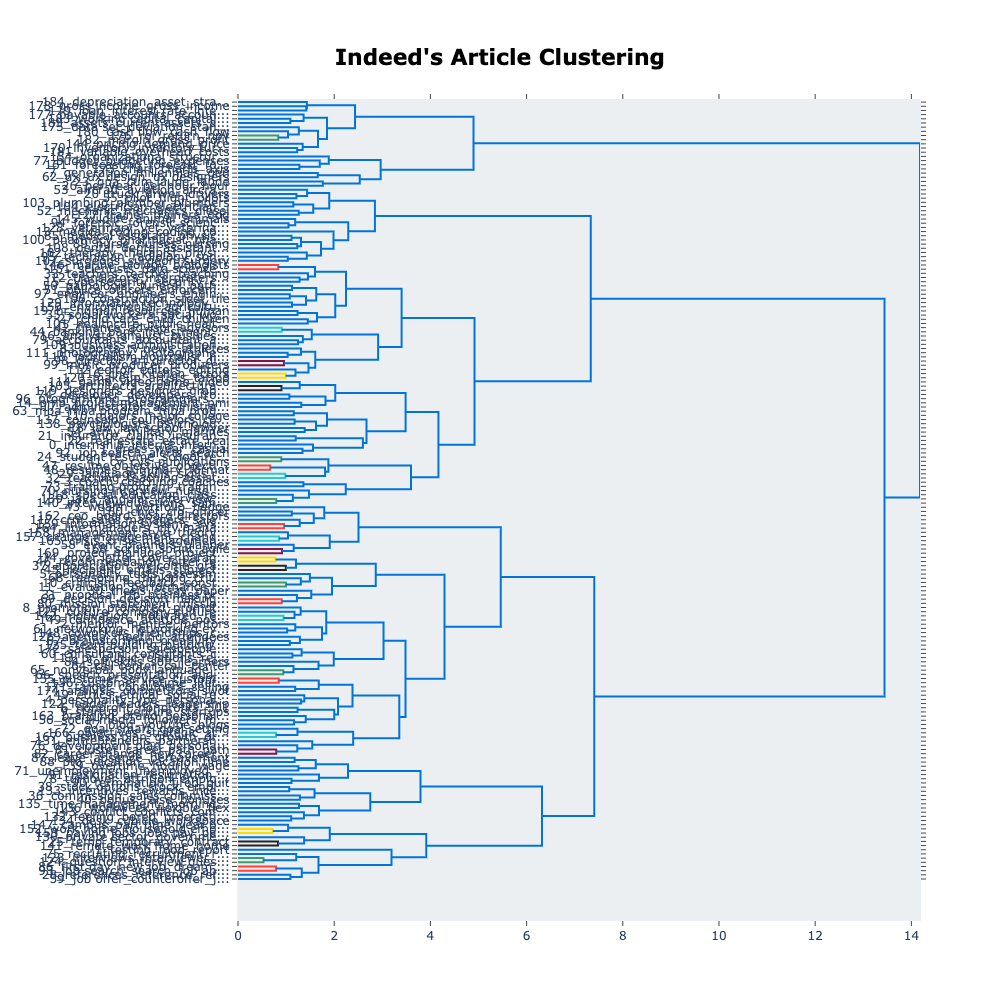

In [33]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (30).png") 

Zoomed in View
--

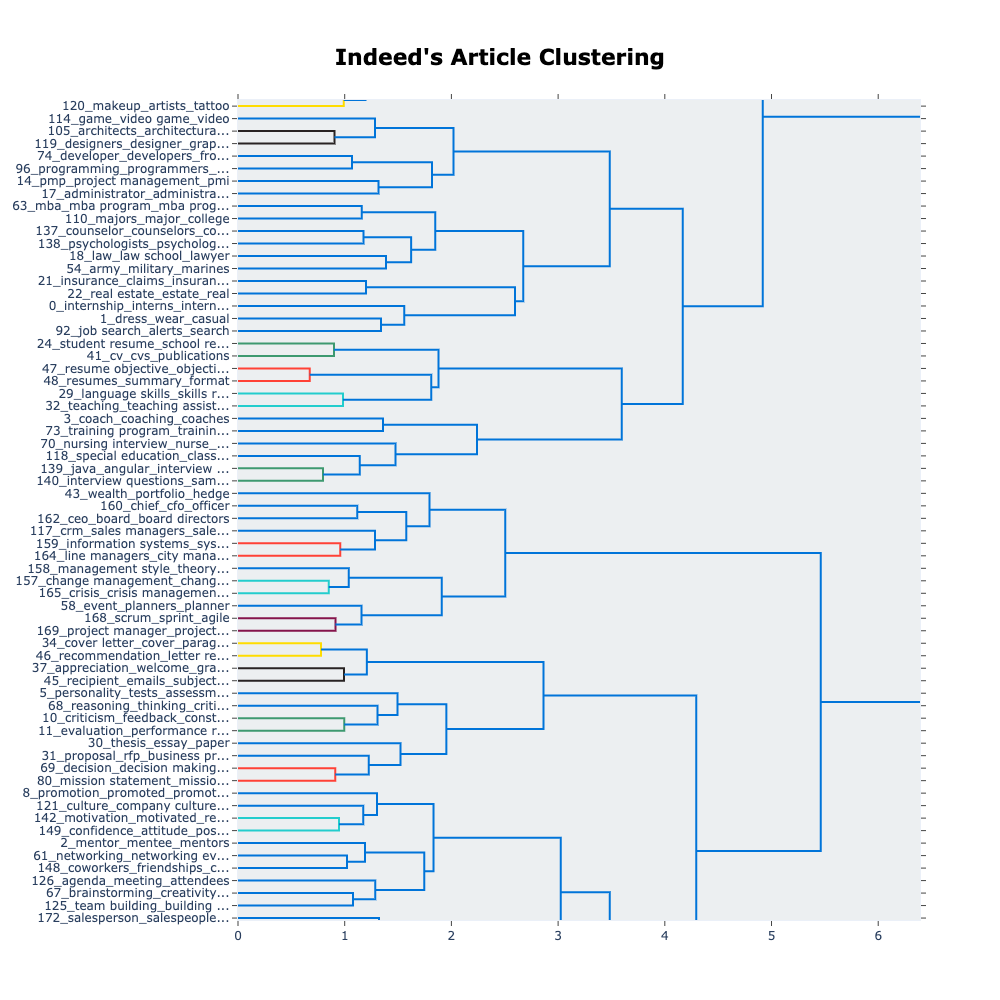

In [34]:
from IPython.display import Image
Image(filename="/Users/gurpreetbedi/Downloads/newplot (31).png") 

Merging Two Topic (if required)
--
**Note: Only run it if you know what topics to merge, otherwise skip it.** 
**Useful in the case when there are some topics which user wants then to be merged together.**

In [41]:
def merge_topics(topic_to_merge, topic_to_merge_into):
    """
    Merge the Topics if required
    """
    print(f"""
    Topic to be merged {topic_to_merge}:
    {top_10_words[topic_to_merge]}
    Topics to merge into {topic_to_merge_into}:
    {top_10_words[topic_to_merge_into]}
    \n
    """)

    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Title': ' '.join})
    m = len(content)
    tf_idf, count = doc_tf_idf(docs_per_topic.Title.values, m)
    top_words = get_top_n_words(tf_idf, count, docs_per_topic, n=10)
    topic_sizes = get_topic_sizes(docs_df)
    return tf_idf, count, top_words, topic_sizes

tf_idf, count, top_10_words, topic_sizes = merge_topics(topic_to_merge=0,topic_to_merge_into=0)
topic_sizes.head(10)

New articles Predictions using Tf-IDF
--

In [35]:
content = list(art_test["cont_title"])
titles = list(art_test['contentTitle'])

In [36]:
embedding_model = "msmarco-MiniLM-L-12-v3"
device = "cuda" if torch.cuda.is_available else "cpu"
test_embeddings = Sentence_Encoder(embedding_model).embed_documents(content, device=device)

In [37]:
test_embeddings.shape

(1417, 384)

In [56]:
test_umap_embeddings = umap_model.transform(test_embeddings)

In [57]:
test_umap_embeddings.shape

(1417, 10)

In [58]:
predictions, probabilities = hdbscan.approximate_predict(hdbscan_model, test_umap_embeddings)
topic_distr = hdbscan.membership_vector(cluster, test_umap_embeddings)

Percentage distribution of Topic with respect to aricles
--

In [59]:
prediction_df = pd.DataFrame(titles, columns=["Title"])
prediction_df["Topic"] = predictions
prediction_df["Probabilities"] = probabilities
words_tfidf = [top_10_words[topic] for topic in predictions]
words = []
for word in words_tfidf:
    word_check = [w[0] for w in word]
    words.append(word_check)
prediction_df["Top_10_words"] = words

In [60]:
prediction_df[:20]

Title  Topic  \
0    How To Tell Someone "That's Not My Job" (With Tips and Examples)     -1   
1               What Is the Theory of Constraints and How Is It Used?     -1   
2       What Is Thinking Strategically? Definition and How To Improve     -1   
3       Thinking vs. Feeling in the Workplace: What's the Difference?     -1   
4                                 17 Tips for Working With New Bosses     -1   
5                     5 To-Do List Methods for Improving Productivity     -1   
6                                      20 DevOps Tools and Their Uses     -1   
7     6 of the Toughest Sales Interview Questions with Sample Answers     -1   
8                 How To Train the Team: Team Training Types and Tips     -1   
9                        What Are the Benefits of Six Sigma Training?     -1   
10                                  7 Types of Architectural Drawings     49   
11       A Guide to Bar Graphs and 6 Steps on How To Draw a Bar Graph     -1   
12                             26 Types of Beams Used in Construction     -1   
13             4 Types of Confined Spaces You Might Encounter at Work     -1   
14  Algebraic Mathematical Equations: Definitions, Types and Examples     -1   
15                          9 Types of Fiction Genres (With Examples)     -1   
16                                         9 Types of Media Marketing     -1   
17                                 The 4 Types of Nursing Assessments     -1   
18                              13 Types of Phlebotomy Certifications     -1   
19                            19 Different Types of Psychology Majors     58   

    Probabilities  \
0             0.0   
1             0.0   
2             0.0   
3             0.0   
4             0.0   
5             0.0   
6             0.0   
7             0.0   
8             0.0   
9             0.0   
10            1.0   
11            0.0   
12            0.0   
13            0.0   
14            0.0   
15            0.0   
16            0.0   
17            0.0   
18            0.0   
19            1.0   

                                                                                                                     Top_10_words  
0                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
1                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
2                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
3                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
4                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
5                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
6                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
7                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
8                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
9                                                  [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
10  [police, criminal, enforcement, officers, law enforcement, justice, correctional, criminal justice, officer, police officers]  
11                                                 [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
12                                                 [sports, food, relations, game, risk, report, gpa, operations, travel, safety]  
13                                                 [sports, food, relations, game, risk, repo

In [50]:
prediction_df.to_csv(f"/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/approximate_predictions_{len(np.unique(cluster.labels_))}.csv")

Each Topic Distribution with respect to each article
--

In [61]:
new_preds = defaultdict(list)
top_words = defaultdict(list)

for j, title in enumerate(titles):
    for i in np.argsort(topic_distr[j],axis=0)[::-1][:10]:
        new_preds["Title"].append(title)
        words = top_10_words[i]
        check = []
        for word in words:
            check.append(word[0])
        new_preds["Perc"].append(round(topic_distr[j][i],5))
        new_preds["Top Words"].append(check)
        
prediction_df = pd.DataFrame.from_dict(new_preds)

In [62]:
prediction_df.iloc[:30]

Title     Perc  \
0   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00818   
1   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00716   
2   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00699   
3   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00699   
4   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00689   
5   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00686   
6   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00686   
7   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00684   
8   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00679   
9   How To Tell Someone "That's Not My Job" (With Tips and Examples)  0.00679   
10             What Is the Theory of Constraints and How Is It Used?  0.00819   
11             What Is the Theory of Constraints and How Is It Used?  0.00713   
12             What Is the Theory of Constraints and How Is It Used?  0.00710   
13             What Is the Theory of Constraints and How Is It Used?  0.00704   
14             What Is the Theory of Constraints and How Is It Used?  0.00702   
15             What Is the Theory of Constraints and How Is It Used?  0.00695   
16             What Is the Theory of Constraints and How Is It Used?  0.00693   
17             What Is the Theory of Constraints and How Is It Used?  0.00688   
18             What Is the Theory of Constraints and How Is It Used?  0.00688   
19             What Is the Theory of Constraints and How Is It Used?  0.00686   
20     What Is Thinking Strategically? Definition and How To Improve  0.00812   
21     What Is Thinking Strategically? Definition and How To Improve  0.00706   
22     What Is Thinking Strategically? Definition and How To Improve  0.00705   
23     What Is Thinking Strategically? Definition and How To Improve  0.00699   
24     What Is Thinking Strategically? Definition and How To Improve  0.00690   
25     What Is Thinking Strategically? Definition and How To Improve  0.00689   
26     What Is Thinking Strategically? Definition and How To Improve  0.00684   
27     What Is Thinking Strategically? Definition and How To Improve  0.00680   
28     What Is Thinking Strategically? Definition and How To Improve  0.00679   
29     What Is Thinking Strategically? Definition and How To Improve  0.00679   

                                                                                                                                                        Top Words  
0                            [personality, tests, assessment, aptitude, test, personality tests, pre employment, assessment tests, personality test, assessments]  
1                                                       [personality type, personality, infps, personalities, intps, istj, personality types, briggs, esfj, istp]  
2                      [evaluation, performance review, 360, reviews, 360 degree, evaluations, performance, employee performance, appraisal, performance reviews]  
3                          [recruiting, recruitment, recruiters, recruiter, headhunter, candidates, talent, talent acquisition, headhunters, recruitment process]  
4                                      [interview questions, interviewer, answers, question, interviewers, sample answers, developer, answer, java, ask question]  
5     [criticism, constructive, feedback, constructive criticism, negative feedback, positive feedback, constructive feedback, negative, critique, feedback loop]  
6              [references, reference, reference list, requisition, job requisition, peer reference, address reference, ask references, peer, business reference]  
7   [training program, onboarding, training programs, sales training, employee training, training development, training needs, trainees, hire training, new hire]  
8   [conflict, conflicts, conflict management, adversity, resolution, confl

In [63]:
prediction_df.to_csv(f"/Users/gurpreetbedi/Downloads/Neural/Final/final/Final/this_final/Project-Indeed/src/Neural/approximate_predictions_perc_distribution_{len(np.unique(cluster.labels_))}.csv")